In [33]:
import os
import shutil
import matplotlib.pyplot as plt 
import cv2 as cv 
import numpy as np
from PIL import Image
import glob
import torch

## Set Working Paths

In [49]:
project_dir = os.getcwd()
print(project_dir)

/home/gomaa/Ai/projects/Car-Damage-Segmentation


In [48]:
!pwd

/home/gomaa/Ai/projects/Car-Damage-Segmentation


In [ ]:
%cd ../
!pwd

/home/gomaa/Ai/projects/Car-Damage-Segmentation
/home/gomaa/Ai/projects/Car-Damage-Segmentation


/home/gomaa/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [38]:
dataset_dir = "data/Car-Damages-5"
data_dir = os.path.join(f"{os.getcwd()}","data")
dataset_dir = os.path.join(f"{os.getcwd()}", dataset_dir) 
print(dataset_dir)
print(data_dir)


/home/gomaa/Ai/projects/Car-Damage-Segmentation/data/Car-Damages-5
/home/gomaa/Ai/projects/Car-Damage-Segmentation/data


In [39]:
!ls {dataset_dir}

README.dataset.txt  README.roboflow.txt  test  train  valid


In [40]:
os.listdir()

['.gitignore',
 'yolov8n-seg.pt',
 'install_dataset.py',
 'convert_dataset_format.py',
 'notebooks',
 '.git',
 'yolov8s-seg.pt',
 'data',
 'README.md',
 'roboflow_api_key.txt']

## A Brief Dataset Overview

In [6]:
mask = cv.imread(dataset_dir + "/train/dst_car-damages-12-_png.rf.408fe1400dd5e271ad0144d311f578e9_mask.png", cv.IMREAD_GRAYSCALE)

img = cv.imread(dataset_dir + "/train/dst_car-damages-12-_png.rf.408fe1400dd5e271ad0144d311f578e9.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)


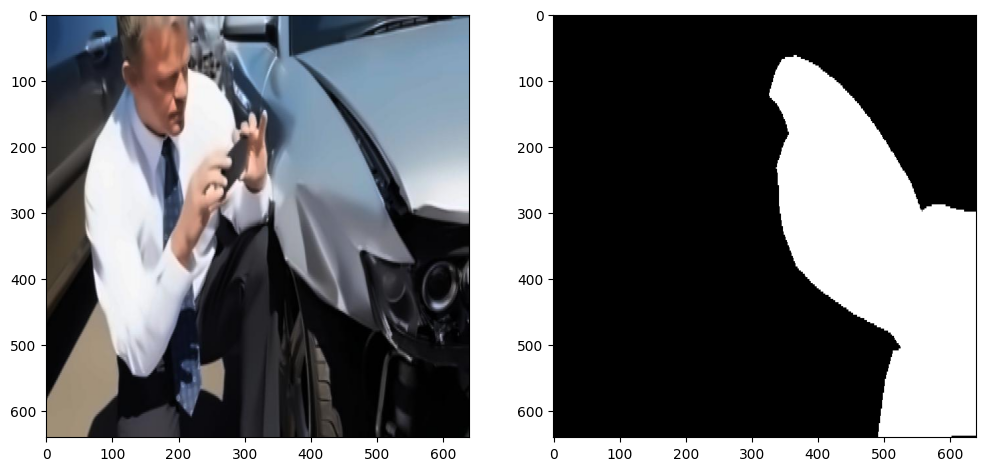

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')


In [8]:
_, thresh = cv.threshold(mask, 1, 255, cv.THRESH_BINARY)
print(mask)
print(thresh)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 4 4 4]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


### Convert a single Mask to Yolo Coordinates

In [9]:
def convert_mask(mask_path, min_area = 50,pixel_to_class=None):
    
    mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    h,w = mask.shape

    label_lines = []

    # Detect all unique pixel values in the mask (ignore background=0)
    unique_vals = np.unique(mask)
    unique_vals = [v for v in unique_vals if v != 0]
    if pixel_to_class is None:
        pixel_to_class = {v: i for i, v in enumerate(sorted(unique_vals))}
        
    for pixel_val, class_id in pixel_to_class.items():
        binary = np.where(mask == pixel_val, 255, 0).astype("uint8")
        # Find Contours
        contours, _ = cv.findContours(binary,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)


        for contour in contours:
            area = cv.contourArea(contour)

            if area < min_area:
                continue

            # flatten contour to be in yolo format (x1 y1 x2 y2 .... xn yn)
            contour = contour.reshape(-1,2)

            # Normalize with width and height
            poly = []
            for x,y in contour:
                x = x/w
                y = y/h
                poly.append(x)
                poly.append(y)

            # Check if valid poly
            if len(poly) < 6: # Less than 3 points
                continue
            
            # Add Polygon Segment 
            line = f"{class_id} " + " ".join(f"{point:.6f}" for point in poly)   
            
            label_lines.append(line)

    return label_lines

    

## Prepare YOLO Directories

In [10]:
def prepare_dirs(data_dir, nc = 2, class_names = ["No Damage", "Severe Damage"]):
    # root dir
    dataset_dir = "dataset"
    if dataset_dir not in os.listdir(data_dir):
        os.mkdir(os.path.join(data_dir,dataset_dir))
        
    else:
        print("dataset dir already exists")
    dataset_dir = os.path.join(data_dir,dataset_dir)
   
    # sub dir
    sub_dirs = ["train", "valid", "test"]
    for dir in sub_dirs:
        if dir not in os.listdir(dataset_dir):
            os.mkdir(os.path.join(dataset_dir,dir))
            os.mkdir(os.path.join(dataset_dir,os.path.join(dir,"images")))
            os.mkdir(os.path.join(dataset_dir,os.path.join(dir,"labels")))
        else:
            print(f"{dir} dir already exists")

    # Create data.yaml file
    yaml_text = f""" 
train: {(os.path.join(dataset_dir,os.path.join("train","images")))}
val:   {os.path.join(dataset_dir,os.path.join("valid","images"))}
test:  {os.path.join(dataset_dir,os.path.join("test","images"))}
nc: {nc}
names: {class_names}
        """
    with open(os.path.join(dataset_dir,'data.yaml'), 'w') as dy:
        dy.write(yaml_text) 

    return dataset_dir

## Load images from original dataset

In [11]:
def load_imgs(dataset_dir, from_yolo=False):
    imgs = {}
    if from_yolo:
        train_imgs = glob.glob(os.path.join(dataset_dir,'train/images/*.jpg'))
        valid_imgs = glob.glob(os.path.join(dataset_dir,'valid/images/*.jpg'))
        test_imgs = glob.glob(os.path.join(dataset_dir,'test/images/*.jpg'))
    else:
        train_imgs = glob.glob(os.path.join(dataset_dir,'train/*.jpg'))
        valid_imgs = glob.glob(os.path.join(dataset_dir,'valid/*.jpg'))
        test_imgs = glob.glob(os.path.join(dataset_dir,'test/*.jpg'))

    imgs['train'] = sorted(train_imgs)
    imgs['valid'] = sorted(valid_imgs)
    imgs['test'] = sorted(test_imgs)


    print(len(imgs['train']))
    print(len(imgs['valid']))
    print(len(imgs['test']))

    return imgs


## Load masks from original dataset

In [12]:
def load_masks(dataset_dir, from_yolo=False):
    masks = {}
    
    if from_yolo:
        train_masks = glob.glob(os.path.join(dataset_dir,'train/labels/*.png'))
        valid_masks = glob.glob(os.path.join(dataset_dir,'valid/labels/*.png'))
        test_masks = glob.glob(os.path.join(dataset_dir,'test/labels/*.png'))
    else: 
        train_masks = glob.glob(os.path.join(dataset_dir,'train/*.png'))
        valid_masks = glob.glob(os.path.join(dataset_dir,'valid/*.png'))
        test_masks = glob.glob(os.path.join(dataset_dir,'test/*.png'))
    masks['train'] = sorted(train_masks)
    masks['valid'] = sorted(valid_masks)
    masks['test'] = sorted(test_masks)

    print(len(masks['train']))
    print(len(masks['valid']))
    print(len(masks['test']))

    return masks

## Move images and labels from original dataset to YOLO dataset

In [13]:
def move_dataset(dataset_dir, dataset_yolo):
    imgs = load_imgs(dataset_dir)
    masks = load_masks(dataset_dir)

    dirs = ['train', 'valid', 'test']
    for dir in dirs:
        dst_i = os.path.join(dataset_yolo,f"{dir}/images") 
        for img in imgs[dir]:
            if img not in os.listdir(dst_i):
                shutil.copy(img, os.path.join(dst_i))

        dst_m = os.path.join(dataset_yolo,f"{dir}/labels")
        for mask in masks[dir]:
            lines = convert_mask(mask, pixel_to_class={3:0, 4:1})

            base_name = os.path.splitext(os.path.basename(mask))[0]
            base_name = base_name.replace("_mask","")
            label_file = os.path.join(dst_m, f"{base_name}.txt")

            # Write lines to .txt
            with open(label_file, "w") as f:
                for line in lines:
                    f.write(line + "\n")


## Pipeline

In [41]:
imgs = load_imgs(dataset_dir)
print(os.path.basename(imgs['train'][5]))

502
68
28
dst_car-damages-124-_png.rf.ab7a9db9690d884abf636fb5fbd7b181.jpg


In [45]:
masks = load_masks(dataset_dir)
print(os.path.basename(masks['train'][5]))


502
68
28
dst_car-damages-124-_png.rf.ab7a9db9690d884abf636fb5fbd7b181_mask.png


In [43]:
yolo_dataset_dir = prepare_dirs(data_dir)
print(yolo_dataset_dir)

dataset dir already exists
train dir already exists
valid dir already exists
test dir already exists
/home/gomaa/Ai/projects/Car-Damage-Segmentation/data/dataset


In [44]:
move_dataset(dataset_dir, yolo_dataset_dir)

502
68
28
502
68
28


## Helper Debugging functions

In [ ]:
def print_per_mask_pixel_values(mask_paths):
    """
    For every mask file, prints its unique pixel values separately.
    """
    for mask_path in mask_paths:
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠ Could not read mask: {mask_path}")
            continue

        unique_vals = np.unique(mask)
        print(f"{mask_path} → {unique_vals}")


In [21]:

def print_unique_mask_values(mask_paths):
    """
    Takes a list of mask file paths, reads each mask,
    and prints all unique pixel values found across the dataset.
    """
    unique_values = set()

    for mask_path in mask_paths:
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠ Could not read mask: {mask_path}")
            continue
        
        values = np.unique(mask)
        unique_values.update(values)

    print("Unique pixel values found:", sorted(unique_values))


In [ ]:
masks = load_masks(dataset_dir)
print_unique_mask_values(masks["test"])
print_per_mask_pixel_values(masks['test'])

502
68
28
Unique pixel values found: [np.uint8(0), np.uint8(3), np.uint8(4)]
/home/gomaa/Ai/projects/Car-Damage-Segmentation/notebooks/../data/Car-Damages-5/test/dst_car-damages-201-_png.rf.91f93440f7f5a3c37cccdc27d2bc66fc_mask.png → [0 4]
/home/gomaa/Ai/projects/Car-Damage-Segmentation/notebooks/../data/Car-Damages-5/test/dst_car-damages-208-_png.rf.74e9abab89c442dd60cb674a8d4ec223_mask.png → [0 4]
/home/gomaa/Ai/projects/Car-Damage-Segmentation/notebooks/../data/Car-Damages-5/test/dst_car-damages-213-_png.rf.6e289075333fc17630ef2e8b6b66f086_mask.png → [0 4]
/home/gomaa/Ai/projects/Car-Damage-Segmentation/notebooks/../data/Car-Damages-5/test/dst_car-damages-281-_png.rf.9db043384420372de77449bbb503c08c_mask.png → [0 3]
/home/gomaa/Ai/projects/Car-Damage-Segmentation/notebooks/../data/Car-Damages-5/test/dst_car-damages-287-_png.rf.10d20ea8681ba00a1b05bdaf8bd8c353_mask.png → [0 3]
/home/gomaa/Ai/projects/Car-Damage-Segmentation/notebooks/../data/Car-Damages-5/test/dst_car-damages-405-_pn

In [24]:
from collections import Counter
def print_mask_pixel_histogram(mask_paths):
    """
    Builds a histogram of pixel values across all mask images
    and prints counts for each pixel level.
    """
    pixel_counter = Counter()

    for mask_path in mask_paths:
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠ Could not read mask: {mask_path}")
            continue

        unique, counts = np.unique(mask, return_counts=True)

        for val, cnt in zip(unique, counts):
            pixel_counter[val] += cnt

    print("Pixel value histogram across all masks:")
    for val in sorted(pixel_counter.keys()):
        print(f"  Value {val}: {pixel_counter[val]} pixels")

In [25]:
masks = load_masks(dataset_dir)
print_mask_pixel_histogram(masks["train"])

502
68
28
Pixel value histogram across all masks:
  Value 0: 122793523 pixels
  Value 3: 32194820 pixels
  Value 4: 52485457 pixels


In [46]:
print(yolo_dataset_dir)

/home/gomaa/Ai/projects/Car-Damage-Segmentation/data/dataset


## Test CUDA

In [47]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())


2.6.0+cu124
12.4
91501


In [28]:
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU count: 1
Device: NVIDIA GeForce RTX 2050


## Train Model

In [50]:
import ultralytics
from ultralytics import YOLO
 
data_path =os.path.join(yolo_dataset_dir,'data.yaml')
model_path= os.path.join(project_dir,"models")

model = YOLO("yolov8n-seg.pt")
result = model.train(data=data_path,epochs=100,imgsz=640,batch=8,device=0, project=model_path)

New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.230 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2050, 3769MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/gomaa/Ai/projects/Car-Damage-Segmentation/data/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, mul

## Test trained model

In [ ]:
trained_model = YOLO(os.path.join(model_path, "train/weights/best.pt"))
res = trained_model.predict(source=imgs['test'],save=True, imgsz=640)


0: 640x640 1 Severe Damage, 9.9ms
1: 640x640 (no detections), 9.9ms
2: 640x640 1 Severe Damage, 9.9ms
3: 640x640 1 Severe Damage, 9.9ms
4: 640x640 1 No Damage, 9.9ms
5: 640x640 1 No Damage, 9.9ms
6: 640x640 1 Severe Damage, 9.9ms
7: 640x640 1 Severe Damage, 9.9ms
8: 640x640 1 Severe Damage, 9.9ms
9: 640x640 1 No Damage, 9.9ms
10: 640x640 2 No Damages, 9.9ms
11: 640x640 1 No Damage, 9.9ms
12: 640x640 1 No Damage, 9.9ms
13: 640x640 1 Severe Damage, 9.9ms
14: 640x640 1 Severe Damage, 9.9ms
15: 640x640 1 No Damage, 9.9ms
16: 640x640 2 No Damages, 9.9ms
17: 640x640 3 No Damages, 9.9ms
18: 640x640 1 No Damage, 9.9ms
19: 640x640 3 No Damages, 9.9ms
20: 640x640 1 Severe Damage, 9.9ms
21: 640x640 1 No Damage, 1 Severe Damage, 9.9ms
22: 640x640 1 No Damage, 9.9ms
23: 640x640 2 No Damages, 9.9ms
24: 640x640 1 Severe Damage, 9.9ms
25: 640x640 1 Severe Damage, 9.9ms
26: 640x640 1 Severe Damage, 9.9ms
27: 640x640 1 Severe Damage, 9.9ms
Speed: 1.3ms preprocess, 9.9ms inference, 0.7ms postprocess per